# Done Soon? Data Analysis

## Import Libraries

In [78]:
import random
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import MaxAbsScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score
import pymongo
import plotly.express as px
from tqdm.notebook import tqdm
import multiprocessing as mp

## Get Data - Mongodb

In [17]:
conn_str = f"mongodb://localhost"
mongo_client = pymongo.MongoClient(conn_str, port=27017)

#all data
all_data = pd.DataFrame(mongo_client.done_soon.problems.find({}))
all_data = all_data[all_data['error'] !=True ]
#manual filtering (1hour)
timeout_after_hour = all_data[all_data.time_to_solution > 7199 * 1000] #>2hours
finishes_before_lower_bound = all_data[all_data.time_to_solution < 30 * 1000] #<30 sec
finishes_after_lower_bound = all_data[all_data.time_to_solution > 30 * 1000] #>30 sec

#print result filtering / Sanity check
print(f"Unsolved: {len(timeout_after_hour)}")
print(f"Solved after lower bound: {len(finishes_after_lower_bound) - len(timeout_after_hour)}")
print(f"Solved before lower bound: {len(finishes_before_lower_bound)}")

#number of values of len of stats
finishes_after_lower_bound.statistics.map(len).value_counts()

Unsolved: 788
Solved after lower bound: 595
Solved before lower bound: 13485


17     56
19     55
24     54
27     54
25     50
       ..
104     1
129     1
158     1
70      1
161     1
Name: statistics, Length: 128, dtype: int64

In [18]:
all_data

,_id,mzn,dzn,generated_features,generated_label,claimed_features_generation,claimed_label_generation,type,time_to_solution,time_limit,solved,statistics,error,was_error
2,63481481fdd73d481158c785,pattern-set-mining/pattern_set_mining_k1.mzn,pattern-set-mining/data/kr-vs-kp.dzn,True,True,True,True,SAT,7208604.0,72000000.0,True,"[{'percent': 1.0836111111111111e-09, 'features...",NaN,NaN
3,63481481fdd73d481158c787,pattern-set-mining/pattern_set_mining_k1.mzn,pattern-set-mining/data/vowel.dzn,True,True,True,True,OPT,949327.0,72000000.0,True,"[{'percent': 1.356388888888889e-09, 'features'...",NaN,NaN
5,63481481fdd73d481158c78b,rcpsp-wet/rcpsp-wet.mzn,rcpsp-wet/data/j90_48_4-wet.dzn,True,True,True,True,SAT,7200267.0,72000000.0,True,"[{'percent': 1.5972222222222224e-11, 'features...",NaN,NaN
6,63481481fdd73d481158c790,rcpsp-wet/rcpsp-wet.mzn,rcpsp-wet/data/j30_35_9-wet.dzn,True,True,True,True,OPT,796.0,72000000.0,True,"[{'percent': 7.083333333333333e-12, 'features'...",NaN,NaN
7,63481481fdd73d481158c791,rcpsp-wet/rcpsp-wet.mzn,rcpsp-wet/data/j30_43_10-wet.dzn,True,True,True,True,OPT,59182.0,72000000.0,True,"[{'percent': 5.6944444444444444e-12, 'features...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17109,63481489fdd73d4811590465,2DBinPacking/2DLevelPacking.mzn,2DBinPacking/data/Class9_80_4.dzn,True,True,True,True,OPT,1411685.0,72000000.0,True,"[{'percent': 3.363888888888889e-10, 'features'...",NaN,NaN
17110,63481489fdd73d4811590466,2DBinPacking/2DLevelPacking.mzn,2DBinPacking/data/Class4_20_4.dzn,True,True,True,True,OPT,17042.0,72000000.0,True,"[{'percent': 1.636111111111111e-10, 'features'...",NaN,NaN
17111,63481489fdd73d4811590467,2DBinPacking/2DLevelPacking.mzn,2DBinPacking/data/Class8_20_7.dzn,True,True,True,True,OPT,111.0,72000000.0,True,"[{'percent': 1.1319444444444445e-10, 'features...",NaN,NaN
17112,63481489fdd73d4811590468,2DBinPacking/2DLevelPacking.mzn,2DBinPacking/data/Class5_100_8.dzn,True,True,True,True,None,NaN,72000000.0,False,"[{'percent': 2.323611111111111e-10, 'features'...",NaN,NaN


In [19]:
all_data['time_to_solution'].isna().sum()

2045

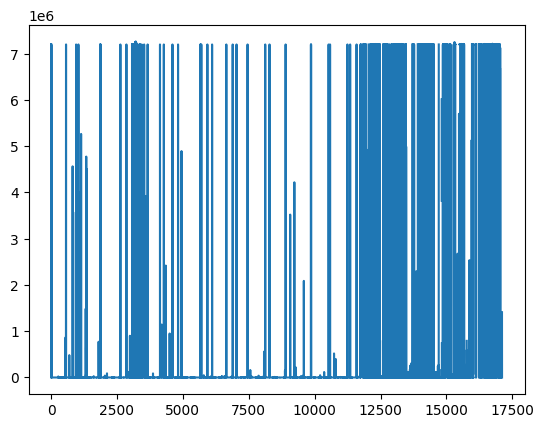

In [20]:
plt.plot(all_data['time_to_solution'])



In [21]:
#test
#finishes_after_lower_bound.statistics[1]

In [22]:
def cleanup(df):
    del df["decision_level_sat"]
    del df["ewma_decision_level_mip"]
    del df["decision_level_mip"]
    del df["best_objective"]
    #df["unassnVar"]   = (2**df['vars']) - df['opennodes']
    #df["fracFailUnassn"]     = df['conflicts'] / df['unassnVar']         # num failures/ num open nodes
    df["fracOpenVisit"]  = (df['vars'] - df['opennodes']) / df['opennodes']       # ratio of open nodes to visited nodes (how much of soln space explored)
    df["fracBoolVars"]     = df['boolVars'] / df['vars']                 # num bools / total num of vars
    df["fracPropVars"]     = df['propagations'] / df['vars']        # num propagations/ total num of vars
    #df["frac_unassigned"] = df['unassnVar'] / df['vars']  # current assignments/ total vars
    #df["fracLongClauses"] = df['long'] / (df['long'] + df['bin'] + df['tern'])         # fraction of learnt clauses that have more than 3 literals
    df["freqBackjumps"]  = df['back_jumps']/df['search_time']
    return df

In [23]:
def gradients(df_prev, df_curr):
    keys=['conflicts','ewma_conflicts','decisions','search_iterations','opennodes','ewma_opennodes',
          'vars','back_jumps','ewma_back_jumps','solutions','total_time','search_time','intVars',
          'propagations','sat_propagations','ewma_propagations','propagators','boolVars','learnt',
          'bin','tern','long','peak_depth','decision_level_engine','ewma_decision_level_engine',
          'decision_level_treesize','clause_mem','prop_mem','ewma_best_objective',
          'fracOpenVisit','fracBoolVars','fracPropVars','freqBackjumps']
    for i in keys:
        df_curr[i+'_gradient']=(df_curr[i]-df_prev[i])/0.05*7200
    return df_curr

In [27]:
features_at_percent = {}
for i in tqdm(range(1, 100)):
    df_i=[]
    for id, problem in all_data.iterrows():
        for index, p in enumerate(problem.statistics):
            if index == i:
                new_p = dict(p['features'])
                new_p=cleanup(new_p)
                if i!=1:
                    new_p=gradients(df_prev.loc[id], new_p)
                new_p['mzn'] = problem['mzn']
                new_p['dzn'] = problem['dzn']
                new_p['solved_within_time_limit'] = problem['time_to_solution'] < 7199 * 1000 \
                or np.logical_not(np.isnan(problem['time_to_solution']))
                df_i.append((id, new_p))
    df_i = pd.DataFrame([a[1] for a in df_i], index=[a[0] for a in df_i])
    df_i=df_i.fillna(value = 0)
    if i!=0:   
        features_at_percent[i]=df_i
    df_prev=df_i

  0%|          | 0/99 [00:00<?, ?it/s]

In [28]:
nans=features_at_percent[20].isna().sum().to_numpy().nonzero()

In [29]:
features_at_percent[20].keys()[nans]

Index([], dtype='object')

In [30]:
features_at_percent[20]

,conflicts,ewma_conflicts,decisions,search_iterations,opennodes,ewma_opennodes,vars,back_jumps,ewma_back_jumps,solutions,...,clause_mem_gradient,prop_mem_gradient,ewma_best_objective_gradient,fracOpenVisit_gradient,fracBoolVars_gradient,fracPropVars_gradient,freqBackjumps_gradient,mzn,dzn,solved_within_time_limit
2,37189,37170.0,38523,17597,35996,35996.24,36007,58,0.00,140,...,0.0,0.0,0.0,-4.001778,0.000000,8.223683e+07,-4.001295e+02,pattern-set-mining/pattern_set_mining_k1.mzn,pattern-set-mining/data/kr-vs-kp.dzn,True
3,255860,255841.0,257909,253015,10469,10468.80,10479,1792,0.00,36,...,0.0,0.0,0.0,27.530809,0.000000,6.163339e+08,-1.780986e+04,pattern-set-mining/pattern_set_mining_k1.mzn,pattern-set-mining/data/vowel.dzn,True
5,555712,555693.0,1148659,341488,73964,73961.55,74036,554481,2.70,456,...,0.0,0.0,0.0,3.897471,0.000000,1.324517e+07,1.768826e+06,rcpsp-wet/rcpsp-wet.mzn,rcpsp-wet/data/j90_48_4-wet.dzn,True
10,543804,543785.0,1103014,641,61579,61578.33,61636,487399,1.14,888,...,0.0,0.0,-2736000.0,-11.753539,0.749291,4.502322e+07,3.063659e+05,rcpsp-wet/rcpsp-wet.mzn,rcpsp-wet/data/j90_10_10-wet.dzn,True
18,943442,943423.0,944302,1471823,19269,19268.33,19274,708,0.00,15,...,0.0,0.0,0.0,-7.475471,0.000000,1.747412e+08,-1.978881e+03,golomb/golomb.mzn,golomb/data/12.dzn,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17107,947893,947874.0,1017940,1965834,6658,6659.17,6710,69995,0.12,0,...,0.0,0.0,0.0,-109.067084,0.000000,2.038405e+07,-4.163697e+05,2DBinPacking/2DLevelPacking.mzn,2DBinPacking/data/Class4_40_7.dzn,False
17108,522895,522876.0,714304,1237200,26142,26140.91,26226,191324,0.04,0,...,0.0,0.0,0.0,0.000000,0.000000,6.075854e+06,-8.085343e+04,2DBinPacking/2DLevelPacking.mzn,2DBinPacking/data/Class4_80_8.dzn,False
17109,743694,743675.0,821989,1565684,31087,31086.59,31122,78258,0.04,0,...,0.0,0.0,0.0,0.000000,0.000000,1.352172e+07,-7.133157e+05,2DBinPacking/2DLevelPacking.mzn,2DBinPacking/data/Class9_80_4.dzn,True
17112,208696,208677.0,211871,420568,46334,46334.14,46345,3163,0.00,0,...,0.0,0.0,0.0,0.000000,0.000000,8.152632e+07,1.302072e+04,2DBinPacking/2DLevelPacking.mzn,2DBinPacking/data/Class5_100_8.dzn,False


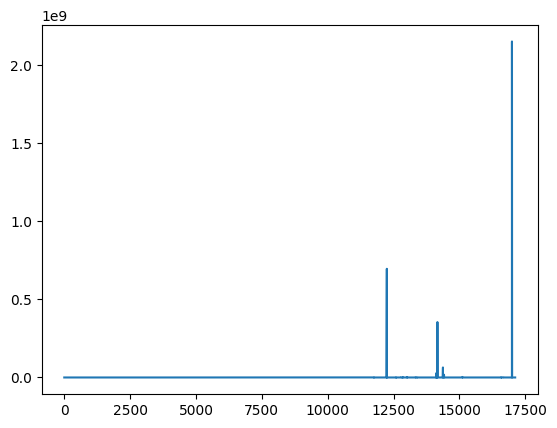

In [31]:
plt.plot(features_at_percent[10]['ewma_best_objective'])

# Data Analysis
## Train Test Split

In [32]:
def preprocessing(df):
    df1=df.drop(['mzn','dzn'], axis=1)
    df1.drop(df1.columns[df1.nunique() == 1], axis=1, inplace=True) #drop cols with constant value
    #rescale data
    transformer = MaxAbsScaler().fit(df1)
    df1 = pd.DataFrame(transformer.transform(df1), columns=df1.columns, index=df1.index) #normalise data
    return df1

In [44]:
def create_split(df, test_size=0.25, random_state=22):
    return train_test_split(df.drop(columns = ["solved_within_time_limit"]),\
                                df["solved_within_time_limit"], test_size=0.25, random_state=22)

In [45]:
df=features_at_percent[20] #THE NUMBER HERE IS THE % OF TL
df=preprocessing(df)
random_state = 22
# training-testing split
X_train, X_test, y_train, y_test  = create_split(df, random_state=random_state)

In [46]:
y_test.value_counts()

0.0    304
1.0    214
Name: solved_within_time_limit, dtype: int64

In [47]:
y_train.value_counts()

0.0    908
1.0    645
Name: solved_within_time_limit, dtype: int64

## Models

In [48]:
models = {}

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models['LR'] = LogisticRegression(max_iter=1000, C=1000 , class_weight = 'balanced',random_state=random_state)

#Support Vector Machine
from sklearn.svm import SVC
models['SVM'] = SVC(kernel = 'rbf', class_weight = 'balanced', probability = True, random_state=random_state)

# Random Forest
from sklearn.ensemble import RandomForestClassifier
models['RF'] = RandomForestClassifier(min_samples_leaf = 5, class_weight = 'balanced_subsample',random_state=random_state)

#Extra Tree
from sklearn.ensemble import ExtraTreesClassifier
models['ET'] = ExtraTreesClassifier(class_weight = 'balanced', random_state=random_state)

#Multi-layered perceptron
from sklearn.neural_network import MLPClassifier
models['MLP'] = MLPClassifier(random_state=random_state)

# Naive Bayes
#from sklearn.naive_bayes import GaussianNB
#models['NB'] = GaussianNB()

# Adaboost
#from sklearn.ensemble import AdaBoostClassifier
#models['AB'] = AdaBoostClassifier()

#KNN
#from sklearn.neighbors import KNeighborsClassifier
#models['KNN'] = KNeighborsClassifier(weights = 'distance')

# Decision Trees
from sklearn.tree import DecisionTreeClassifier
models['DT'] = DecisionTreeClassifier(max_depth = 5, class_weight = 'balanced', random_state=random_state)

#Dummy classifier
from sklearn.dummy import DummyClassifier
models['DUM'] = DummyClassifier(strategy="most_frequent")

f1 score is 0.8867924528301887


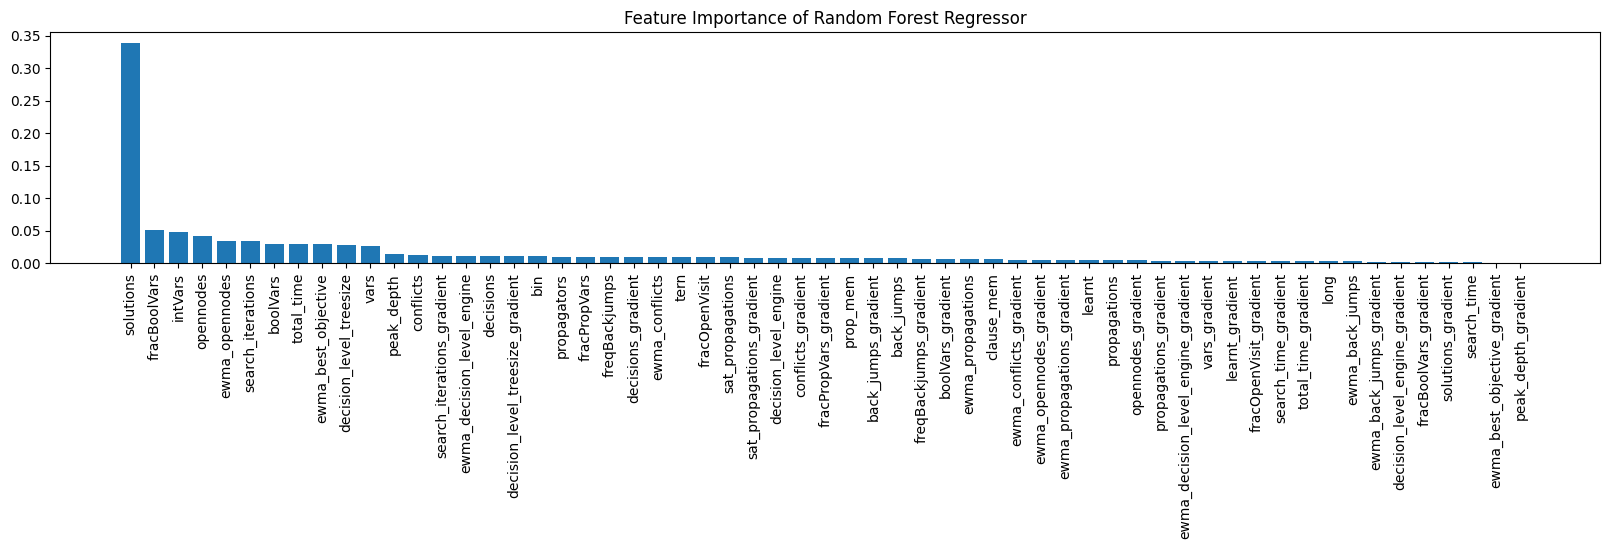

In [53]:
# rf_reg = RandomForestClassifier(min_samples_leaf = 5)
models["RF"].fit(X_train,y_train)
predictions = models["RF"].predict(X_test)
print('f1 score is', f1_score(y_test, predictions))


importances = rf_reg.feature_importances_

# Sort the feature importance in descending order
sorted_indices = np.argsort(importances)[::-1]

plt.title('Feature Importance of Random Forest Regressor')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.rcParams["figure.figsize"] = (20,3)
plt.show()

## Predicitions and Evaluation

In [50]:
def results_plt(X_train, y_train, X_test, y_test, perc_TL):
    train_accuracy, accuracy, precision, recall, auc, f1 = {}, {}, {}, {}, {}, {}
    figs, axs = plt.subplots(2,3,figsize=(20, 12))

    for i, key in enumerate(models.keys()):

        # Fit the classifier model
        models[key].fit(X_train, y_train)

        predictions = models[key].predict(X_test)
        predictions_prob = models[key].predict_proba(X_test)[:,1]
        train_predictions = models[key].predict(X_train)
        # Predic  
        # Calculate Accuracy, Precision and Recall Metrics
        accuracy[key] = accuracy_score(predictions, y_test)
        precision[key] = precision_score(predictions, y_test, zero_division=1)
        recall[key] = recall_score(predictions, y_test, zero_division=1)
        auc[key] = roc_auc_score(y_test, predictions_prob)
        train_accuracy[key] = accuracy_score(train_predictions, y_train)
        f1[key] = f1_score(y_test,predictions)
        #should it be (true, pred)? yes

        #To Display
        RocCurveDisplay.from_predictions(y_test, predictions_prob, name=key , ax=axs[0,0])
        axs[0,1].bar(key, accuracy[key]) 
        axs[0,2].bar(key, train_accuracy[key]) 
        axs[1,0].bar(key, recall[key])
        axs[1,1].bar(key, precision[key])
        axs[1,2].bar(key, f1[key])

        axs[0,0].set_title("ROC Curve for "+perc_TL+"% TL")
        #axs[0].set_ylabel("Accuracy")

        axs[0,1].set_title("Test Accuracy for "+perc_TL+"% TL")
        axs[0,1].set_xticklabels(models.keys(),rotation=60)
        axs[0,1].set_ylabel("Accuracy")
        axs[0,1].grid(axis='y', color='gray', linestyle='dashed')

        axs[0,2].set_title("Train Accuracy for "+perc_TL+"% TL")
        axs[0,2].set_xticklabels(models.keys(),rotation=60)
        axs[0,2].set_ylabel("Accuracy")
        axs[0,2].grid(axis='y', color='gray', linestyle='dashed')

        axs[1,0].set_title("Recall for "+perc_TL+"% TL")
        axs[1,0].set_xticklabels(models.keys(),rotation=60)
        axs[1,0].set_ylabel("Recall")
        axs[1,0].grid(axis='y', color='gray', linestyle='dashed')


        axs[1,1].set_title("Precision "+perc_TL+"% TL")
        axs[1,1].set_xticklabels(models.keys(),rotation=60)
        axs[1,1].set_ylabel("F1")
        axs[1,1].grid(axis='y', color='gray', linestyle='dashed')

        axs[1,2].set_title("F1 "+perc_TL+"% TL")
        axs[1,2].set_xticklabels(models.keys(),rotation=60)
        axs[1,2].set_ylabel("F1")
        axs[1,2].grid(axis='y', color='gray', linestyle='dashed')
        figs.show()   


/home/reuben/school/idmp-b/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipykernel_455424/1482028916.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0,1].set_xticklabels(models.keys(),rotation=60)
/tmp/ipykernel_455424/1482028916.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0,2].set_xticklabels(models.keys(),rotation=60)
/tmp/ipykernel_455424/1482028916.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1,0].set

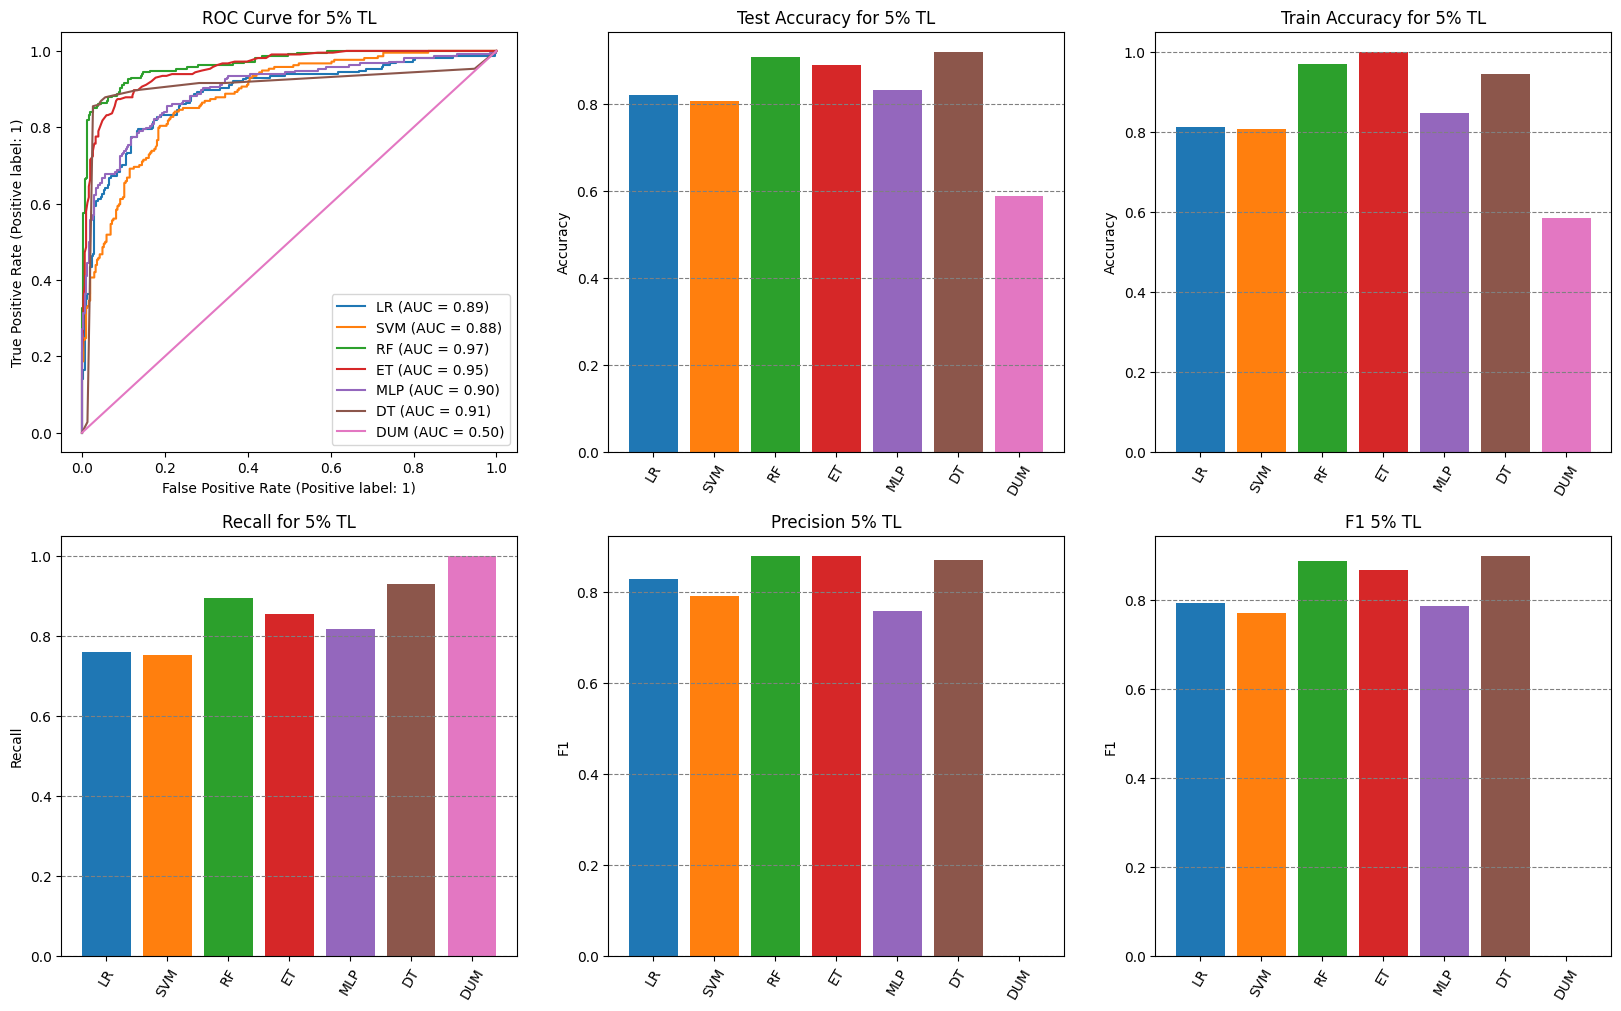

In [51]:
#Bar plot results  for testing and training using top 5 created features

results_plt(X_train, y_train, X_test, y_test, "5")

In [108]:
def get_f1_scores(args):
    features_at_percent, percent, rep = args
    df_at_percent = features_at_percent[percent]
    df_at_percent = preprocessing(df_at_percent)

    X_train, X_test, y_train, y_test  = create_split(df_at_percent, random_state=percent + (100 * rep))
    model = RandomForestClassifier(min_samples_leaf = 5, class_weight = 'balanced_subsample',random_state=percent + (100 * rep))
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    return f1_score(y_test, predictions)

In [109]:
def get_f1_over_time_for_model(features_at_percent, repetitions=10):
    f1_scores_mean = []
    f1_scores_std = []
    for percent in tqdm(range(1, 100), desc="Percent"):
        with mp.Pool(mp.cpu_count()) as pool:
            f1_scores = list(tqdm(pool.imap(get_f1_scores,
                                            [(features_at_percent, percent, rep) for rep in range(repetitions)]),
                                  total=10, leave=False, desc="Repetitions"))
#             for repeat in range(10):
#                 df_at_percent = features_at_percent[percent]
#                 df_at_percent = preprocessing(df_at_percent)

#                 X_train, X_test, y_train, y_test  = create_split(df_at_percent, random_state=percent)
#                 model = RandomForestClassifier(min_samples_leaf = 5, class_weight = 'balanced_subsample',random_state=percent)
#                 model.fit(X_train,y_train)
#                 predictions = model.predict(X_test)
#                 f1_scores.append(f1_score(y_test, predictions))
            f1_scores_mean.append(np.mean(f1_scores))
            f1_scores_std.append(np.std(f1_scores))
        
    return f1_scores_mean, f1_scores_std
    

In [110]:
f1_scores_mean, f1_scores_std = get_f1_over_time_for_model(features_at_percent)

Percent:   0%|          | 0/99 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

Repetitions:   0%|          | 0/10 [00:00<?, ?it/s]

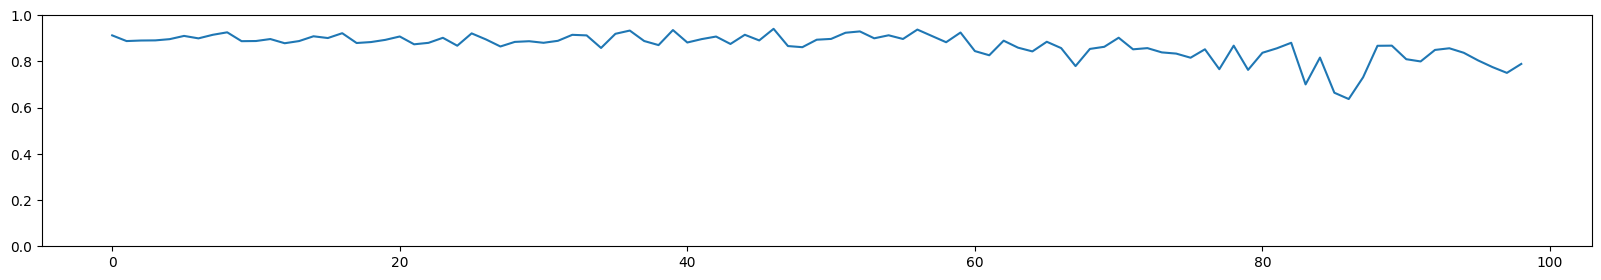

In [115]:
plt.ylim((0, 1))
plt.plot(f1_scores_mean)
# plt.plot(f1_scores_std)

## Regression

# Ignore the rest! 
# -- -- -- -- -- -- 
# -- -- -- -- -- -- 
# -- -- -- -- -- -- 
# -- -- -- -- -- -- 
# -- -- -- -- -- -- 
# -- -- -- -- -- -- 

# **Feature Importance Analysis**

Feature importance for all features

Large error bars may result from Gini Importance being misleading when features have many unique values 



UnboundLocalError: local variable 'c_array' referenced before assignment

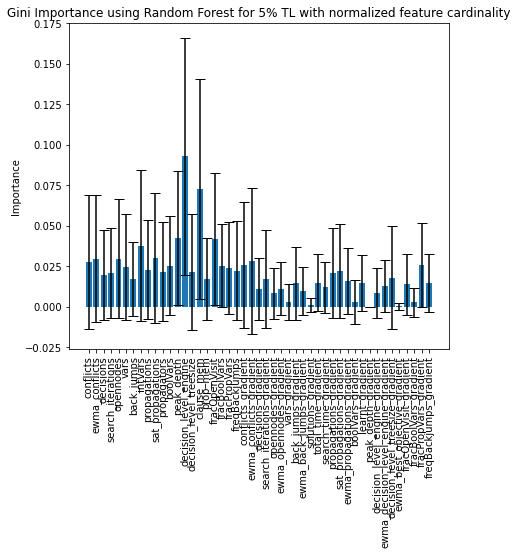

In [78]:
def feat_import_plt(X, y, perc_TL):
    #Display Flags 
    ordered = False   #True displays importances in descending order
    errorbar = True
    cardinality = False
    
    #Drop values that are neither standard chuffed values nor created
    X = X.drop(["solutions",
                "total_time",
                "search_time", #total time - init time
                "learnt" ,
                "bin",
                "tern",
                "long",
                "ewma_opennodes",
                "ewma_decision_level_engine",
                "ewma_back_jumps",
                "ewma_propagations",
                "ewma_best_objective"], axis=1, inplace=False)

    #Feature importance using Gini Impurity
    dcs_t = RandomForestClassifier(min_samples_leaf = 5,random_state=22)
    dcs_t.fit(X, y)
    
    importances = dcs_t.feature_importances_
    std = np.std([tree.feature_importances_ for tree in dcs_t.estimators_], axis=0) #get standard dev of importances
    
    if ordered:
        _sorted_indices = np.argsort(importances)[::-1]   # Sort the feature importance in descending order
    else:
        _sorted_indices = np.array(range(len(importances)))   # unsorted feature importances for comparison

    plt.figure(figsize=(15, 6))
    ax1 = plt.subplot(1, 2, 1)
    plt.title('Gini Importance using Random Forest for '+ perc_TL+'% TL with normalized feature cardinality')
    
    if not errorbar:
        ax1.bar(range(X.shape[1]), importances[_sorted_indices])
    else :
        ax1.bar(range(X.shape[1]), importances[_sorted_indices], yerr=std, ecolor='black', capsize=5, align='center')
        ax1.set_ylabel('Importance')
        plt.xticks(range(X.shape[1]), X.columns[_sorted_indices], rotation=90)

    #print("GI:", importances[sorted_indices])

    if cardinality:
        c = df_5.apply(pd.Series.nunique) #feature cardinalityc_array = []
    for i in X.columns[_sorted_indices]:
        c_array.append(c.loc[i]/ max(df_5.apply(pd.Series.nunique).values))
    
    ax2 = ax1.twinx()
    ax2.plot(range(X.shape[1]), c_array, color = 'r' )
    ax2.set_ylabel('Cardinality', color = 'r')

    #Feature importance using Permutation Importance
    perm = permutation_importance(dcs_t, X, y, random_state = 22)
    if ordered:
        _perm_sorted_indices = np.argsort(perm.importances_mean)[::-1] # Sort the feature importance in descending order
    else:
        _perm_sorted_indices = _sorted_indices

    ax3 = plt.subplot(1, 2, 2)
    plt.title('Permutation Importance using Random Forest for '+ perc_TL+'% TL')
    if not errorbar:
        ax3.bar(range(X.shape[1]), perm.importances_mean[_perm_sorted_indices]*10)
    else:
        ax3.bar(range(X.shape[1]), perm.importances_mean[_perm_sorted_indices]*10, yerr=perm.importances_std, ecolor='black', capsize=5, align='center')
    plt.xticks(range(X.shape[1]), X.columns[_perm_sorted_indices], rotation=90)
    ax3.set_ylabel('Importance')

    #print("PI:", perm.importances_mean[perm_sorted_indices])

    if cardinality:
        c_array = []
        for i in X.columns[_perm_sorted_indices]:
            c_array.append(c.loc[i]/ max(df_5.apply(pd.Series.nunique).values))
        ax2 = ax3.twinx()
        ax2.plot(range(X.shape[1]), c_array, color = 'r' )
        ax2.set_ylabel('Cardinality', color = 'r')

    #plt.subplot(1, 3, 3)
    #sns.heatmap(X.corr(), mask = np.triu(X.corr()) )


    plt.tight_layout()
    plt.show()

print("Large error bars may result from Gini Importance being misleading when features have many unique values \n")
feat_import_plt(X_train, y_train,  "5")
# feat_import_plt(X_train_10, y_train_10, "10")
# feat_import_plt(X_train_15, y_train_15,  "15")
# feat_import_plt(X_train_20, y_train_20,  "20")

Feature importance for proposed (or created) features

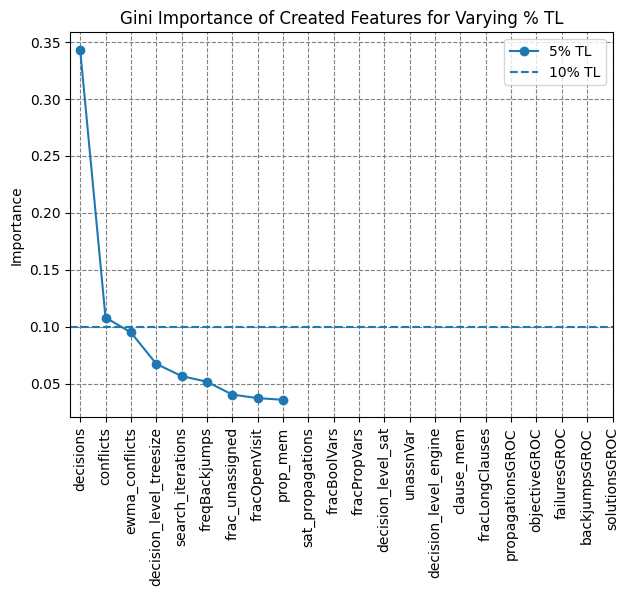

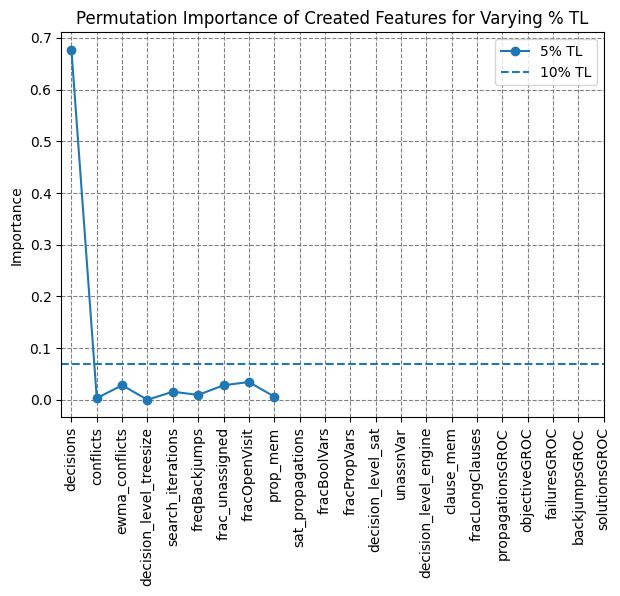

In [103]:
#Only keep proposed features
for df in df_list:
    df.drop(["opennodes",
             "ewma_opennodes",
             "ewma_decision_level_engine",
             "vars",
             "back_jumps",
             "ewma_back_jumps",
             "solutions",
             "total_time",
             "search_time", #total time - init time
             "intVars",
             "propagations",
             "ewma_propagations",
             "propagators",
             "boolVars",
             "learnt" ,
             "bin",
             "tern",
             "long",
             "peak_depth",
             "best_objective",
             "ewma_best_objective"], axis=1, inplace=True)
  
  
  
#dummy vars for df_5 to match size of other dfs
df_5["objectiveGROC"] = np.zeros(df_5.shape[0])
df_5["failuresGROC"] = np.zeros(df_5.shape[0])
df_5["backjumpsGROC"] = np.zeros(df_5.shape[0])
df_5["propagationsGROC"] = np.zeros(df_5.shape[0])
df_5["solutionsGROC"] = np.zeros(df_5.shape[0])


# Resplit dats into training-testing 
Xd_train_5, Xd_test_5, yd_train_5, yd_test_5  = train_test_split(df_5.drop(columns = ["solved_within_time_limit"]),\
                                                     df_5["solved_within_time_limit"], test_size=0.25, random_state=22)

# Xd_train_10, Xd_test_10, yd_train_10, yd_test_10  = train_test_split(df_10.drop(columns = ["solved_within_time_limit"]),\
#                                                      df_10["solved_within_time_limit"], test_size=0.25, random_state=22)

# Xd_train_15, Xd_test_15, yd_train_15, yd_test_15  = train_test_split(df_15.drop(columns = ["solved_within_time_limit"]),\
#                                                      df_15["solved_within_time_limit"], test_size=0.25, random_state=22)

# Xd_train_20, Xd_test_20, yd_train_20, yd_test_20  = train_test_split(df_20.drop(columns = ["solved_within_time_limit"]),\
#                                                      df_20["solved_within_time_limit"], test_size=0.25, random_state=22)
# #Feature importances using only proposed features
def importance (X, y):
  dcs_5 = RandomForestClassifier(min_samples_leaf = 5,random_state=22)
  dcs_5.fit(X, y)
  importances_5 = dcs_5.feature_importances_
  std_5 = np.std([tree.feature_importances_ for tree in dcs_5.estimators_], axis=0) #get standard dev of importances
  perm_5 = permutation_importance(dcs_5, X, y, random_state = 22)
  return importances_5, perm_5

[importances_5, perm_5] = importance(Xd_train_5, yd_train_5)
sorted_indices = np.argsort(importances_5)[::-1] 
perm_sorted_indices = np.argsort(perm_5.importances_mean)[::-1] 

# [importances_10, perm_10] = importance(Xd_train_10, yd_train_10)
# sorted_indices_10 = np.argsort(importances_10)[::-1] 
# perm_sorted_indices_10 = np.argsort(perm_10.importances_mean)[::-1]

# [importances_15, perm_15] = importance(Xd_train_15, yd_train_15)
# sorted_indices_15 = np.argsort(importances_15)[::-1] 
# perm_sorted_indices_15 = np.argsort(perm_15.importances_mean)[::-1] 

# [importances_20, perm_20] = importance(Xd_train_20, yd_train_20)
# sorted_indices_20 = np.argsort(importances_20)[::-1] 
# perm_sorted_indices_20 = np.argsort(perm_20.importances_mean)[::-1] 

#Print images
printAll = True #set to flase to show top 10 features

if printAll:
  plt.figure(figsize=(7, 5))
  plt.title('Gini Importance of Created Features for Varying % TL')
  plt.plot(Xd_train_5.columns[sorted_indices][0:9], importances_5[sorted_indices][0:9],'-o' )
#   plt.plot(Xd_train_10.columns[sorted_indices], importances_10[sorted_indices], '-s')
#   plt.plot(Xd_train_15.columns[sorted_indices], importances_15[sorted_indices], '-^' )
#   plt.plot(Xd_train_20.columns[sorted_indices], importances_20[sorted_indices], '-v')
  plt.axhline(y=0.10, linestyle='--')
  plt.xticks(range(Xd_train_5.shape[1]), Xd_train_5.columns[sorted_indices], rotation=90)
  plt.ylabel('Importance')
  plt.grid(axis='both', color='gray', linestyle='dashed')
  plt.legend(["5% TL", "10% TL", "15% TL", "20% TL"])

  plt.figure(figsize=(7, 5))
  plt.title('Permutation Importance of Created Features for Varying % TL')
  plt.plot(Xd_train_5.columns[sorted_indices][0:9], perm_5.importances_mean[sorted_indices][0:9]*10,'-o' )
#   plt.plot(Xd_train_10.columns[sorted_indices], perm_10.importances_mean[sorted_indices]*10, '-s')
#   plt.plot(Xd_train_15.columns[sorted_indices], perm_15.importances_mean[sorted_indices]*10, '-^' )
#   plt.plot(Xd_train_20.columns[sorted_indices], perm_20.importances_mean[sorted_indices]*10, '-v')
  plt.axhline(y=0.07, linestyle='--')
  plt.xticks(range(Xd_train_5.shape[1]), Xd_train_5.columns[sorted_indices], rotation=90)
  plt.ylabel('Importance')
  plt.grid(axis='both', color='gray', linestyle='dashed')
  plt.legend(["5% TL", "10% TL", "15% TL", "20% TL"])
else:
  plt.figure(figsize=(7, 5))
  plt.title('Top 10 Gini Important Created Features for Varying % TL')
  plt.plot(Xd_train_5.columns[sorted_indices][0:10], importances_5[sorted_indices][0:10],'o' )
  plt.plot(Xd_train_10.columns[sorted_indices_10][0:10], importances_10[sorted_indices_10][0:10], 's')
  plt.plot(Xd_train_15.columns[sorted_indices_15][0:10], importances_15[sorted_indices_15][0:10], '^' )
  plt.plot(Xd_train_20.columns[sorted_indices_20][0:10], importances_20[sorted_indices_20][0:10], 'v')
  plt.axhline(y=0.10, linestyle='--')
  plt.xticks(range(13), Xd_train_5.columns[sorted_indices][0:12], rotation=90)
  plt.ylabel('Importance')
  plt.grid(axis='both', color='gray', linestyle='dashed')
  plt.legend(["5% TL", "10% TL", "15% TL", "20% TL"])

  plt.figure(figsize=(7, 5))
  plt.title('Top 10 Permutation Important Created Features for Varying % TL')
  plt.plot(Xd_train_5.columns[perm_sorted_indices][0:10], perm_5.importances_mean[perm_sorted_indices][0:10]*10,'o' )
  plt.plot(Xd_train_10.columns[perm_sorted_indices_10][0:10], perm_10.importances_mean[perm_sorted_indices_10][0:10]*10, 's')
  plt.plot(Xd_train_15.columns[perm_sorted_indices_15][0:10], perm_15.importances_mean[perm_sorted_indices_15][0:10]*10, '^' )
  plt.plot(Xd_train_20.columns[perm_sorted_indices_20][0:10], perm_20.importances_mean[perm_sorted_indices_20][0:10]*10, 'v')
  plt.axhline(y=0.07, linestyle='--')
  plt.xticks(range(13), Xd_train_5.columns[perm_sorted_indices][0:12], rotation=90)
  plt.ylabel('Importance')
  plt.grid(axis='both', color='gray', linestyle='dashed')
  plt.legend(["5% TL", "10% TL", "15% TL", "20% TL"])


In [108]:
#select top 5 features for training
Xs_train_5  = Xd_train_5.iloc[:, sorted_indices[0:5]]
# Xs_train_10 = Xd_train_10.iloc[:,sorted_indices_10[0:5]]
# Xs_train_15 = Xd_train_15.iloc[:,sorted_indices_15[0:5]]
# Xs_train_20 = Xd_train_20.iloc[:,sorted_indices_20[0:5]]

Xs_test_5  = Xd_test_5.iloc[:,sorted_indices[0:5]]
# Xs_test_10 = Xd_test_10.iloc[:,sorted_indices_10[0:5]]
# Xs_test_15 = Xd_test_15.iloc[:,sorted_indices_15[0:5]]
# Xs_test_20 = Xd_test_20.iloc[:,sorted_indices_20[0:5]]

print("Top 5 features:",Xd_train_5.columns[sorted_indices][0:5])

Top 5 features: Index(['decisions', 'conflicts', 'ewma_conflicts', 'decision_level_treesize',
       'search_iterations'],
      dtype='object')


# **Predictions and Evaluation**

In [89]:
def results_plt(X_train, y_train, X_test, y_test, perc_TL):
    train_accuracy, accuracy, precision, recall, auc, f1 = {}, {}, {}, {}, {}, {}
    figs, axs = plt.subplots(1,6,figsize=(35, 5))

    for i, key in enumerate(models.keys()):

        # Fit the classifier model
        models[key].fit(X_train, y_train)

        predictions = models[key].predict(X_test)
        predictions_prob = models[key].predict_proba(X_test)[:,1]
        train_predictions = models[key].predict(X_train)
        # Predic  
        # Calculate Accuracy, Precision and Recall Metrics
        accuracy[key] = accuracy_score(predictions, y_test)
        precision[key] = precision_score(predictions, y_test, zero_division=1)
        recall[key] = recall_score(predictions, y_test, zero_division=1)
        auc[key] = roc_auc_score(y_test, predictions_prob)
        train_accuracy[key] = accuracy_score(train_predictions, y_train)
        f1[key] = f1_score(y_test,predictions)
        #should it be (true, pred)? yes

        #To Display
        RocCurveDisplay.from_predictions(y_test, predictions_prob, name=key , ax=axs[0])
        axs[1].bar(key, accuracy[key]) 
        axs[2].bar(key, train_accuracy[key]) 
        axs[3].bar(key, recall[key])
        axs[4].bar(key, precision[key])
        axs[5].bar(key, f1[key])

        axs[0].set_title("ROC Curve for "+perc_TL+"% TL")
        #axs[0].set_ylabel("Accuracy")

        axs[1].set_title("Test Accuracy for "+perc_TL+"% TL")
        axs[1].set_xticklabels(models.keys(),rotation=60)
        axs[1].set_ylabel("Accuracy")
        axs[1].grid(axis='y', color='gray', linestyle='dashed')

        axs[2].set_title("Train Accuracy for "+perc_TL+"% TL")
        axs[2].set_xticklabels(models.keys(),rotation=60)
        axs[2].set_ylabel("Accuracy")
        axs[2].grid(axis='y', color='gray', linestyle='dashed')

        axs[3].set_title("Recall for "+perc_TL+"% TL")
        axs[3].set_xticklabels(models.keys(),rotation=60)
        axs[3].set_ylabel("Recall")
        axs[3].grid(axis='y', color='gray', linestyle='dashed')


        axs[4].set_title("Precision "+perc_TL+"% TL")
        axs[4].set_xticklabels(models.keys(),rotation=60)
        axs[4].set_ylabel("F1")
        axs[4].grid(axis='y', color='gray', linestyle='dashed')

        axs[5].set_title("F1 "+perc_TL+"% TL")
        axs[5].set_xticklabels(models.keys(),rotation=60)
        axs[5].set_ylabel("F1")
        axs[5].grid(axis='y', color='gray', linestyle='dashed')
        figs.show()   

/var/folders/c_/26gzmft14_ggmc3hk5fqsmvh0000gn/T/ipykernel_48650/1445637629.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(models.keys(),rotation=60)
/var/folders/c_/26gzmft14_ggmc3hk5fqsmvh0000gn/T/ipykernel_48650/1445637629.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(models.keys(),rotation=60)
/var/folders/c_/26gzmft14_ggmc3hk5fqsmvh0000gn/T/ipykernel_48650/1445637629.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(models.keys(),rotation=60)
/var/folders/c_/26gzmft14_ggmc3hk5fqsmvh0000gn/T/ipykernel_48650/1445637629.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[4].set_xticklabels(models.keys(),rotation=60)
/var/folders/c_/26gzmft14_ggmc3hk5fqsmvh0000gn/T/ipykernel_48650/1445637629.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  

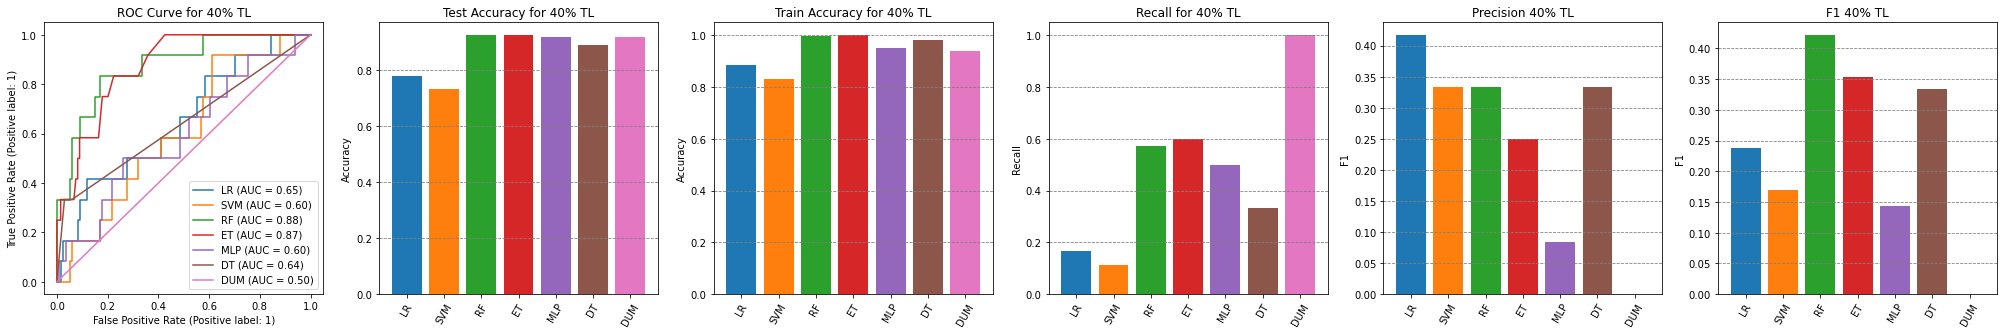

In [93]:
#Bar plot results  for testing and training using top 5 created features
results_plt(X_train, y_train, X_test, y_test, "40")

In [112]:
def results_line_plt(X_train, y_train, X_test, y_test, perc_TL):
  train_accuracy, accuracy, precision, recall, auc, f1 = {}, {}, {}, {}, {}, {}
  #figs, axs = plt.subplots(1,6,figsize=(35, 5))

  for i, key in enumerate(models.keys()):

          # Fit the classifier model
          models[key].fit(X_train, y_train)

          # Prediction
          predictions = models[key].predict(X_test)
          predictions_prob = models[key].predict_proba(X_test)[:,1]
          train_predictions = models[key].predict(X_train)

          # Calculate Accuracy, Precision and Recall Metrics
          accuracy[key] = accuracy_score(predictions, y_test)
          precision[key] = precision_score(predictions, y_test, zero_division=1)
          recall[key] = recall_score(predictions, y_test, zero_division=1)
          auc[key] = roc_auc_score(y_test, predictions_prob)
          train_accuracy[key] = accuracy_score(train_predictions, y_train)
          f1[key] = f1_score(y_test,predictions)
          #should it be (true, pred)? yes
  print("\n------------------------------------------------------------------------")
  print(perc_TL+"% TL train acc:", np.round(list(train_accuracy.values()),2))
  print(perc_TL+"% TL test acc :", np.round(list(accuracy.values()),2))
  print(perc_TL+"% TL precision:",  np.round(list(precision.values()),2))
  print(perc_TL+"% TL recall   :",  np.round(list(recall.values()),2))
  print(perc_TL+"% TL F1       :",  np.round(list(f1.values()),2))
  print(perc_TL+"% TL ROC AUC  :",  np.round(list(auc.values()),2))
  print("------------------------------------------------------------------------")
  return train_accuracy, accuracy, precision, recall, auc, f1

  



------------------------------------------------------------------------
5% TL train acc: [0.9  0.9  0.96 1.   0.9  0.98 0.9 ]
5% TL test acc : [0.86 0.87 0.9  0.89 0.86 0.92 0.86]
5% TL precision: [1.   0.86 0.92 0.95 1.   0.94 1.  ]
5% TL recall   : [0.86 0.98 0.96 0.93 0.86 0.96 0.86]
5% TL F1       : [0.93 0.92 0.94 0.94 0.93 0.95 0.93]
5% TL ROC AUC  : [0.94 0.94 0.95 0.95 0.5  0.85 0.5 ]
------------------------------------------------------------------------


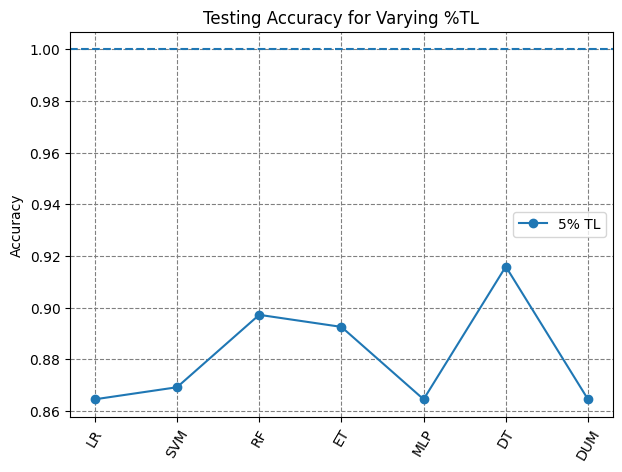

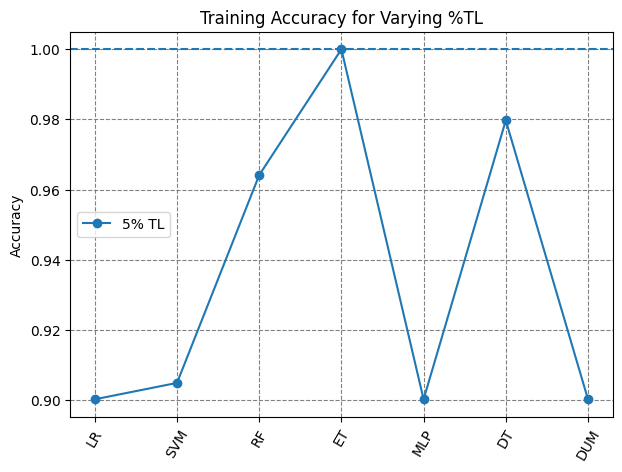

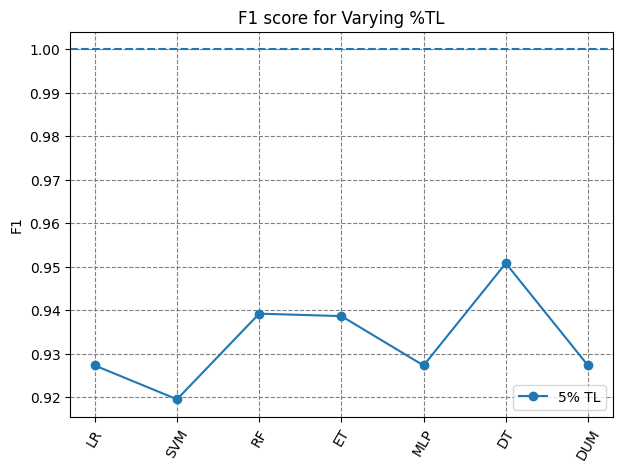

In [114]:

#Line plot results  for testing and training using top 5 created features
train_accuracy_5, accuracy_5, precision_5, recall_5, auc_5, f1_5 = results_line_plt(Xs_train_5, yd_train_5, Xs_test_5, yd_test_5, "5")
# train_accuracy_10, accuracy_10, precision_10, recall_10, auc_10, f1_10 = results_line_plt(Xs_train_10, yd_train_10, Xs_test_10, yd_test_10, "10")
# train_accuracy_15, accuracy_15, precision_15, recall_15, auc_15, f1_15 = results_line_plt(Xs_train_15, yd_train_15, Xs_test_15, yd_test_15, "15")
# train_accuracy_20, accuracy_20, precision_20, recall_20, auc_20, f1_20 = results_line_plt(Xs_train_20, yd_train_20, Xs_test_20, yd_test_20, "20")

plt.figure(figsize=(7, 5))
plt.title("Testing Accuracy for Varying %TL")
plt.plot(list(accuracy_5.keys()), list(accuracy_5.values()), '-o') 
# plt.plot(list(accuracy_10.keys()), list(accuracy_10.values()), '-s') 
# plt.plot(list(accuracy_15.keys()), list(accuracy_15.values()), '-^') 
# plt.plot(list(accuracy_20.keys()), list(accuracy_20.values()), '-v') 
plt.axhline(y=1, linestyle='--')
plt.xticks(range(len(models)), models.keys(),rotation=60)
plt.ylabel('Accuracy')
plt.grid(axis='both', color='gray', linestyle='dashed')
plt.legend(["5% TL"]) #, "10% TL", "15% TL", "20% TL"])

plt.figure(figsize=(7, 5))
plt.title("Training Accuracy for Varying %TL")
plt.plot(list(train_accuracy_5.keys()), list(train_accuracy_5.values()),'-o') 
# plt.plot(list(train_accuracy_10.keys()), list(train_accuracy_10.values()), '-s') 
# plt.plot(list(train_accuracy_15.keys()), list(train_accuracy_15.values()), '-^') 
# plt.plot(list(train_accuracy_20.keys()), list(train_accuracy_20.values()), '-v') 
plt.axhline(y=1, linestyle='--')
plt.xticks(range(len(models)), models.keys(),rotation=60)
plt.ylabel('Accuracy')
plt.grid(axis='both', color='gray', linestyle='dashed')
plt.legend(["5% TL"]) #, "10% TL", "15% TL", "20% TL"])

plt.figure(figsize=(7, 5))
plt.title("F1 score for Varying %TL")
plt.plot(list(f1_5.keys()), list(f1_5.values()),'-o') 
# plt.plot(list(f1_10.keys()), list(f1_10.values()), '-s') 
# plt.plot(list(f1_15.keys()), list(f1_15.values()), '-^') 
# plt.plot(list(f1_20.keys()), list(f1_20.values()), '-v') 
plt.axhline(y=1, linestyle='--')
plt.xticks(range(len(models)), models.keys(),rotation=60)
plt.ylabel('F1')
plt.grid(axis='both', color='gray', linestyle='dashed')
plt.legend(["5% TL"]) #, "10% TL", "15% TL", "20% TL"])

plt.show() 

f1 score is 0.375


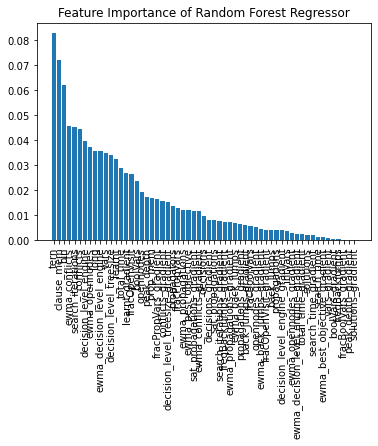

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
#confusion_matrix(y_test_5,predictions)
plot_confusion_matrix(rf_reg, X_test_20, y_test_20)

In [ ]:
df_20.describe()

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(min_samples_leaf = 5)
scores = cross_val_score(rf, df_20.drop('solved_within_time_limit', axis=1), df_20['solved_within_time_limit'], cv=5, scoring='f1')
scores

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score

skf = StratifiedKFold(n_splits=5, shuffle=True)
X = df_20.drop('solved_within_time_limit', axis=1)
y = df_20['solved_within_time_limit']
for train, test in skf.split(X, y):
    rf = RandomForestClassifier(min_samples_leaf = 5)
    rf.fit(X.iloc[train], y.iloc[train])
    pred = rf.predict(X.iloc[test])
    print(len(y.iloc[test][y == 1]))
    print(f1_score(y.iloc[test], pred))
    plot_confusion_matrix(rf, X.iloc[test], y.iloc[test])